# CarRacing-v0

In [1]:
import numpy as np
import os
import json
import tensorflow as tf
import random
from vaegan.vaegan import ganVAE
from controller import make_controller
from env import make_env
from utils import PARSER
args = PARSER.parse_args(['--config_path', 'configs/carracing.config'])

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU

DATA_DIR = "results/{}/{}/record".format(args.exp_name, args.env_name)
model_path_name = "results/{}/{}/tf_ganvae".format(args.exp_name, args.env_name)

In [4]:
filelist = os.listdir(DATA_DIR)

In [5]:
obs = np.load(os.path.join(DATA_DIR, random.choice(filelist)))["obs"]
obs = obs.astype(np.float32)/255.0

In [6]:
obs.shape

(972, 64, 64, 3)

In [7]:
frame = random.choice(obs).reshape(1, 64, 64, 3)

In [8]:
vae = ganVAE(args)

vae.set_weights(tf.keras.models.load_model(model_path_name, compile=False).get_weights())

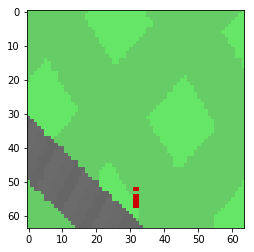

In [9]:
%matplotlib inline
# show recorded frame that will be fed into the input of VAE
plt.imshow(frame[0])
plt.show()

In [10]:
batch_z = vae.encode(frame)
print(batch_z[0]) # print out sampled z
reconstruct = vae.decode(batch_z)

tf.Tensor(
[-0.0077  1.0349  1.6141 -1.5028  0.4152 -0.8105  0.9507 -0.6379  1.0957 -1.0172 -0.5318  1.0752
 -1.2426 -0.4472  0.4696 -1.7027 -1.111  -1.458  -0.8229  0.0768  1.368   0.2122  0.5362  1.1459
 -0.5607 -0.4188 -2.226  -1.0912 -0.1242 -1.2962  0.4093  0.8166], shape=(32,), dtype=float32)


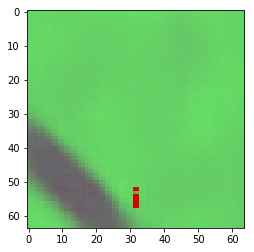

In [11]:
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Dream Samples

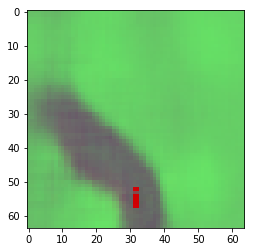

In [12]:
%matplotlib inline
batch_z = tf.random.normal((1, args.z_size)).numpy()
reconstruct = vae.decode(batch_z)
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Driving in true environment
visualize what the agent sees when driving in the true environment

## Return Plot for Controller

In [19]:
eager_filepath = os.path.join('results/{}/{}/log/{}.cma.16.ganvae4.eval_hist.json'.format(args.exp_name, args.env_name, args.env_name))
og_filepath = os.path.join('results/og/log', 'carracing.cma.16.64.hist_best.json')
with open(eager_filepath, 'r') as f:
  eager_data = json.load(f)
with open(og_filepath, 'r') as f:
  og_data = json.load(f)

eager_data = np.array(eager_data)
og_data = np.array(og_data)

eager_comparison_max = eager_data[-1, 0] # b/c we didnt run for 2k
og_max_idx = np.sum(np.array(og_data[: ,0],dtype=np.float) <= eager_comparison_max)
print(og_max_idx)

og_data = np.array(og_data)[:og_max_idx]

2


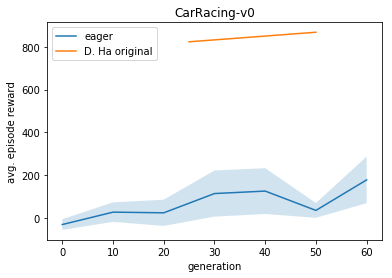

In [20]:
%matplotlib inline

eager_x = eager_data[:, 0]
eager_ret = eager_data[:, 1]
eager_std = eager_data[:, 2]

og_x = np.array(og_data[:, 0], dtype=np.float)
og_ret = np.array(og_data[:, 5], dtype=np.float)
# don't have access to standard deviation of the og evaluation

plt.figure()
plt.plot(eager_x, eager_ret)
plt.fill_between(eager_x, eager_ret-eager_std, eager_ret+eager_std, alpha=0.2)
plt.plot(og_x, og_ret)

plt.title('CarRacing-v0')
plt.ylabel('avg. episode reward')
plt.xlabel('generation')
plt.legend(['eager', 'D. Ha original'])